In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Windows 한글 폰트
mpl.rcParams["font.family"] = "Malgun Gothic"
mpl.rcParams["axes.unicode_minus"] = False


In [2]:
import pandas as pd
import numpy as np
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm import LGBMRegressor


In [3]:
csv_path = "new_flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("전체 데이터 수:", len(df))


C:\Users\Admin\AppData\Local\Temp\ipykernel_7056\2458588365.py:2: DtypeWarning: Columns (28,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


전체 데이터 수: 2843934


In [4]:
reg_df = df[df["상태"] == "지연"].copy()
print("상태=지연 데이터 수:", len(reg_df))

# 타겟 정제
reg_df = reg_df[reg_df["지연_분"].notna()]
reg_df = reg_df[reg_df["지연_분"] >= 0]

MAX_DELAY = 360
reg_df = reg_df[reg_df["지연_분"] <= MAX_DELAY]

print(reg_df["지연_분"].describe())


상태=지연 데이터 수: 481449
count    479872.000000
mean         56.778833
std          35.039417
min           0.000000
25%          36.000000
50%          46.000000
75%          64.000000
max         360.000000
Name: 지연_분, dtype: float64


In [5]:
num_cols = [
    "기온(°C)",
    "풍속_ms",
    "dep_hour",
    "dep_weekday",
    "is_weekend"
]

cat_cols = [
    "공항명",
    "출발지",
    "도착지",
    "flight_type"
]

num_cols = [c for c in num_cols if c in reg_df.columns]
cat_cols = [c for c in cat_cols if c in reg_df.columns]

X_cols = num_cols + cat_cols


In [6]:
reg_df["departure_datetime"] = pd.to_datetime(reg_df["departure_datetime"])
reg_df = reg_df.sort_values("departure_datetime")

split_date = reg_df["departure_datetime"].quantile(0.8)

train_df = reg_df[reg_df["departure_datetime"] <= split_date]
test_df  = reg_df[reg_df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["지연_분"]

X_test  = test_df[X_cols]
y_test  = test_df["지연_분"]

print("Train:", len(X_train), "Test:", len(X_test))


Train: 383897 Test: 95975


In [7]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [8]:
lgbm_reg = Pipeline([
    ("prep", preprocessor),
    ("reg", LGBMRegressor(
        objective="regression",
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

lgbm_reg.fit(X_train, y_train_log)

y_pred_log = lgbm_reg.predict(X_test)
y_pred = np.expm1(y_pred_log)

print("🌳 LightGBM (log target)")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 383897, number of used features: 223
[LightGBM] [Info] Start training from score 3.945879


C:\Users\Admin\anaconda3\envs\4vector\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


🌳 LightGBM (log target)
MAE : 18.146819981154025
RMSE: 28.85824702646577


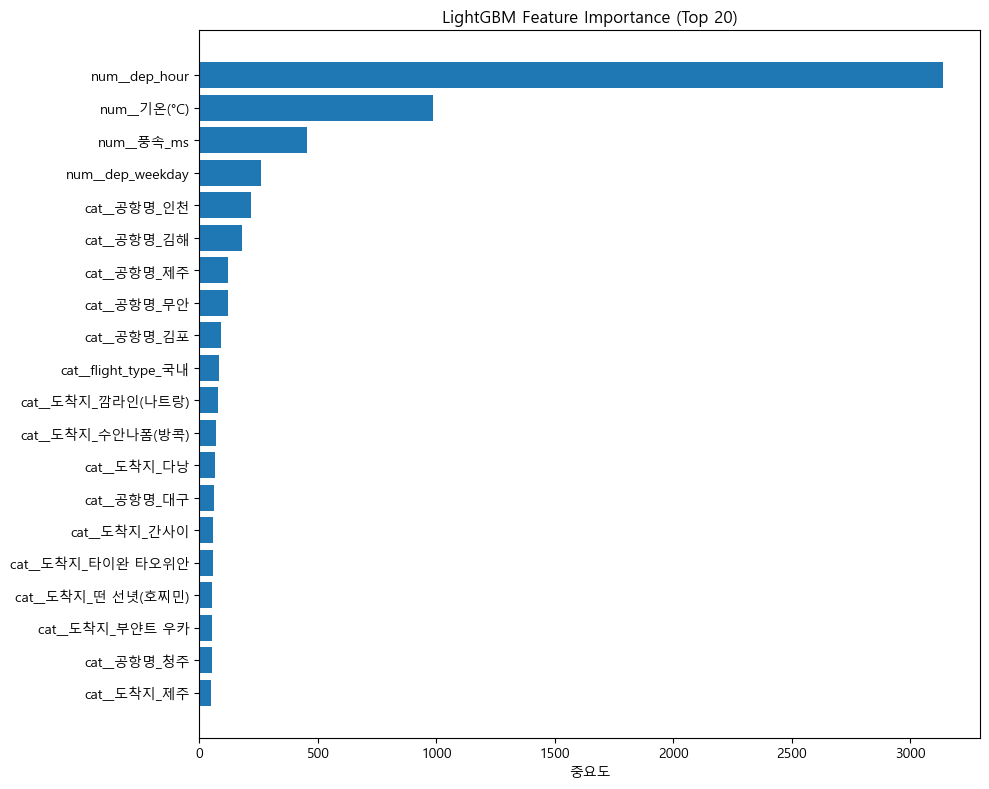

In [9]:
lgbm_model = lgbm_reg.named_steps["reg"]
feature_names = lgbm_reg.named_steps["prep"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": lgbm_model.feature_importances_
}).sort_values("importance", ascending=False)

top_df = importance_df.head(20).iloc[::-1]

plt.figure(figsize=(10, 8))
plt.barh(top_df["feature"], top_df["importance"])
plt.title("LightGBM Feature Importance (Top 20)")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()


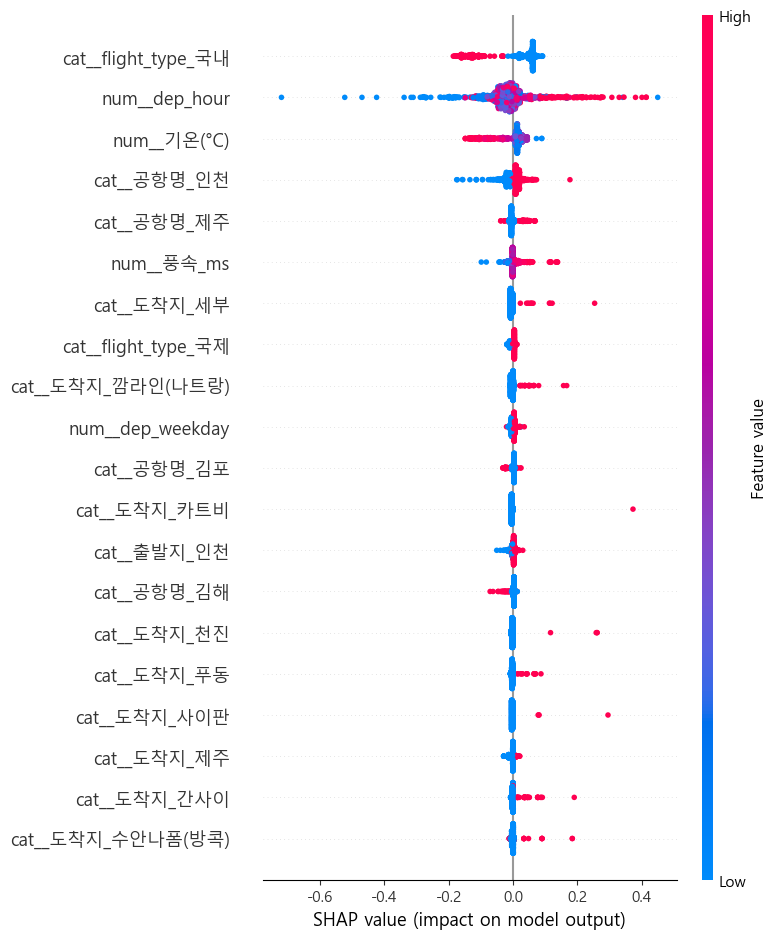

In [13]:
# ===============================
# SHAP (최종 안정 버전)
# ===============================

SHAP_SAMPLE = 1000  # 반드시 정의

# 전처리된 데이터 (dense로 바로 변환)
X_test_dense = lgbm_reg.named_steps["prep"].transform(
    X_test.iloc[:SHAP_SAMPLE]
).toarray()

# ✅ 최신 SHAP 권장 방식
explainer = shap.Explainer(
    lgbm_reg.named_steps["reg"],
    X_test_dense
)

shap_values = explainer(X_test_dense)

# Summary plot
shap.summary_plot(
    shap_values.values,
    X_test_dense,
    feature_names=feature_names,
    max_display=20
)


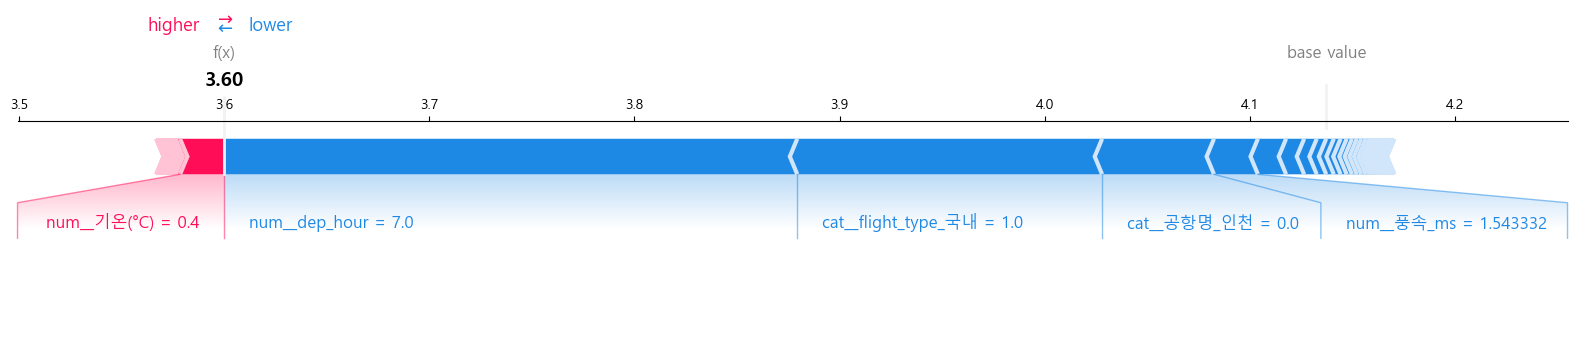

In [14]:
i = 10

shap.force_plot(
    explainer.expected_value,
    shap_values.values[i],
    X_test_dense[i],
    feature_names=feature_names,
    matplotlib=True
)


In [15]:
result_df = pd.DataFrame({
    "actual_delay": y_test.values[:SHAP_SAMPLE],
    "predicted_delay": y_pred[:SHAP_SAMPLE]
})

result_df.head(20)


,actual_delay,predicted_delay
0,37.0,46.665867
1,56.0,85.362395
2,40.0,48.108481
3,38.0,48.108481
4,9.0,34.662479
5,37.0,52.607479
6,70.0,52.607479
7,30.0,36.952680
8,146.0,79.523506
9,73.0,56.551510
